In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [46]:
# Alguns imports úteis 
import matplotlib.pyplot as plt

import shap # shap para criar indicadores de feature importance
from tqdm.notebook import tqdm # tqdm para criar uma barra de loading enquanto estiver num loop

import nltk # biblioteca de nlp
from nltk.tokenize import word_tokenize, TweetTokenizer # funções de tokenização
from nltk.corpus import twitter_samples, stopwords # fuções para acessar algumas bases do nltk

nltk.download('twitter_samples') # base de dados com amostras do twitter
nltk.download('punkt') # recursos de tokenização
nltk.download('stopwords') # lista de stopwords
tweet_tokenizer = TweetTokenizer() # fução específica para tokenizar tweets


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## O que tem nos csvs?

In [47]:
# Visualização básica da informação
def sep():
    print('---')

testDf = pd.read_csv('../input/nlp-getting-started/test.csv')
trainDf = pd.read_csv('../input/nlp-getting-started/train.csv')

testInfo = [testDf.size, testDf['text'],testDf['keyword'].isna().sum(), testDf['location'].isna().sum()]
trainInfo = [trainDf.size, testDf['text'],testDf['keyword'].isna().sum(), testDf['location'].isna().sum()]

print(testDf.head())
sep()
print(testInfo)
sep()
print(trainInfo)
sep()

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
---
[13052, 0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Haz

## EDA

<AxesSubplot:>

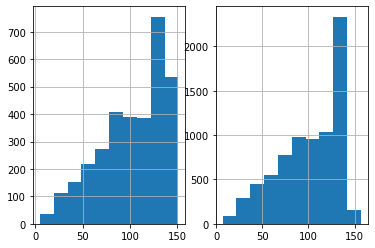

In [48]:
# Como fazer EDA em NLP? 
# https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
# https://towardsai.net/p/nlp/natural-language-processing-concepts-and-workflow-48083d2e3ce7

plt.subplot(121)
testDf['text'].str.len().hist()
plt.subplot(122)
trainDf['text'].str.len().hist()
# Distribuição similar no comprimento dos tweets

## Workflow do Sérgio Souza @thoughtworks

In [61]:
# Preprocessando com NLTK
emojis = [':(', ':-(', '(', ')','>:-(', ':)', ':-)','?','!','...','û_',':','-']
stop_words = stopwords.words('english')+emojis
# print(stop_words) #descomentar para ver stop_words comuns

In [50]:
def count_vect(vect:list, 
               vocab:dict(), 
               stop_words:list=None, 
               lower_case:bool=False,
               skeep_not_found:bool=False,
               )->dict:
  """Função que recebe a lista de tokens, os agrupa e gera o vocabulário

    Args:
        vect (list): lista de tokens de uma amostra
        vocab (dict): vocabulário já existente
        stop_words (list, optional): Lista de stopwords a serem ignoradas. Defaults to None.
        lower_case (bool, optional): Se forçará lower-case em todos os tokens. Defaults to False.
        skeep_not_found (bool, optional): Se ignorará termos que ainda não existem no vocabulário. Defaults to False.

    Returns:
        dict: dicionário contendo os termos da lista de tokens e a frequência
  """

  ct_vect = {}
  # percorre cada token
  for w in vect:
    # se vai forçar lower-case
    if lower_case:
      w = w.lower()
    # ignorando stop_words
    if stop_words:
      if w in stop_words:
        continue
    # se vai ignorar termos não existentes no discionário
    if skeep_not_found:
      if w not in vocab:
        continue
    # adiciona termo novo ao vocabulário e incrementa a frequência
    if w not in vocab:
      vocab[w] = 0
    vocab[w] += 1
    # Adiciona o termo ao discionário de tokens e frequência
    if w not in ct_vect:
      ct_vect[w] = 0
    ct_vect[w] += 1
  return ct_vect

def tokenize_data(list_text:list, stop_words:list=None)->[list, dict]:
  """Recebe lista de strings, stopwords e os transforma em uma lista de discionários de termos e frequência.
  Retornando também o vocabulário encontrado

  Args:
      list_text (list): lista de strings a serem processadas
      stop_words (list, optional): lista de stopwords a serem ignorados. Defaults to None.

  Returns:
      tuple[list, dict]: o primeiro valor é uma lista de discionários com termo e frequência, o segundo valor é o vocabulário com a frequência de todo corpus
  """

  vocab = dict()
  tk_text = []
  
  # itera em cada documento, chamando a função count_vect
  for t in list_text:
    new_t = count_vect(tweet_tokenizer.tokenize(t), vocab, stop_words=stop_words, lower_case=True)
    tk_text.append(new_t)

  return tk_text, vocab

def to_matrix(tk_text:list, vocab:dict)->[list, dict]:
  """Gera uma matriz bag-of-words dos termos identificados e retorna o vocabulário utilizado

    Args:
        tk_text (list): lista de discionários com termo e frequência
        vocab (dict): o vocabulário com a frequência de todo corpus

    Returns:
        tuple[list, dict]: matriz bag-of-words e vocabulário usado
    """
  matrix = []
  temp_vocab = vocab.keys()
  # percorre cada documento
  for text in tqdm(tk_text):
    new_text = []
    # percorre cada termo do vocabulário
    for word in temp_vocab:
      # atribui a frequência encontrada ou zero caso contrário
      if word in text:
        # grava a frequência
        new_text.append(text[word])
      else:
        new_text.append(0)

    matrix.append(new_text)

  return matrix, temp_vocab


def to_predict(text:str, vocab:dict, stop_words:list=None):
  """Transforma um texto em bag-of-words pronto para o modelo

  Args:
      text (str): string a ser transformada
      vocab (dict): vocabulário usado
      stop_words (list, optional): lista de stop_words a serem ignorada. Defaults to None.

  Returns:
      _type_: matriz bag-of-words
  """
  # chamo a função count_vect com skeep_not_found igual a true, não queremos aumentar nosso vocabulário aqui
  new_t = count_vect(tweet_tokenizer.tokenize(text), 
                      vocab, 
                      stop_words=stop_words, 
                      lower_case=True, 
                      skeep_not_found=True)
  # com isso basta chamar to_matrix
  matrix, _ = to_matrix([new_t], vocab)
  return matrix

In [51]:
tweets = trainDf['text']

# tokenizar e criar o vocabulario
tk_text1, vocab1 = tokenize_data(tweets, stop_words)
# criar a matriz bag-of-words
matrix1, columns1 = to_matrix(tk_text1, vocab1)
# convertendo a matriz para um array numpy
matrix1 = np.array(matrix1)
print(matrix1.shape)
# visualizando uma amostra
pd.DataFrame(matrix1[0:10], columns=columns1)

  0%|          | 0/7613 [00:00<?, ?it/s]

(7613, 23020)


,deeds,reason,#earthquake,may,allah,forgive,us,forest,fire,near,...,9km,#la,http://t.co/5uecmcv2pk,forney,developing,symptoms,http://t.co/rqkk15uhey,http://t.co/nf4iculoje,http://t.co/stfmbbzfb5,http://t.co/ymy4rskq3d
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
from sklearn.model_selection import cross_val_score, train_test_split # funções que ajudam a escolher os modelos
from sklearn.metrics import confusion_matrix, f1_score # Métricas para avaliar um modelo de classificação
from sklearn.naive_bayes import GaussianNB # Modelo Naive Bayes com Gaussian
from sklearn.tree import DecisionTreeClassifier # Modelo Decision Tree to Classifier
from sklearn.ensemble import RandomForestClassifier # Modelo Random Forest and Adaboost 

import plotly.graph_objs as go # Para criar os gráficos

def train_models(matrix, labels):
  
  # Dividindo o dado em treino e teste
  X_train, X_test, y_train, y_test = train_test_split(matrix, labels, test_size=0.2, random_state=42)

  # lista de modelos a serem testados
  models = [GaussianNB(),
            DecisionTreeClassifier(),#max_depth=50),          
            RandomForestClassifier(),#max_depth=50, n_estimators=50),
          ]

  # nome dos modelos
  models_name = ["Naive Bayes", "Decision Tree", "Random Forest"]


  # discionários para guardar informações do treinamento
  total_scores = {}
  trained_models = {}
  # for iterando por modelo
  for model, model_name in zip(models, models_name):
      np.random.seed = 42
      # cross validation
      scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1')
      # registra o score médio e o desvio padrão da validação cruzada
      total_scores[model_name] = [scores, scores.mean(), scores.std()]
      # F1 Score
      print("{} -- Training K-Fold mean f1: {:0.3f} (std: {:0.3f})".format(model_name, scores.mean(), scores.std()))
      # Testa o modelo com dados
      y_pred = model.fit(X_train,y_train).predict(X_test)

        
      # Matriz de confusão
      z = confusion_matrix(y_test, y_pred)
      x=['Negative', 'Positive']
      y=['Negative', 'Positive']
      
      # Gerando gráfico no plotly
      annotations = []
      for n, row in enumerate(z):
          for m, val in enumerate(row):
              annotations.append(go.layout.Annotation(text=str(z[n][m]), x=x[m], y=y[n],
                                              xref='x1', yref='y1', showarrow=False))
              
      data = [go.Heatmap(x=x,y=y,z=z,                   
                    colorscale=["white", "lightblue"])] #amp blues peach

      layout = go.Layout(title='Confusion Matrix - {}'.format(model_name), 
                        xaxis={'title' : 'Predicted label'},
                        yaxis={'autorange' : 'reversed', 
                                'title' : 'True Label'})
      
      fig = go.Figure(data=data, layout=layout)
      fig['layout'].update(annotations=annotations, height=350, width=350)
      fig.show()
      # fim da geração do gráfico

      print("{} -- Test f1: {:0.3f}".format(model_name, f1_score(y_test, y_pred)))
      print('----------------------------------------------------------------------------')
      trained_models[model_name] = model

  return trained_models, total_scores, X_test

In [53]:
%%time
labels = trainDf['target']
trained_models1, total_scores1, X_test1 = train_models(matrix1, labels)

Naive Bayes -- Training K-Fold mean f1: 0.651 (std: 0.011)


Naive Bayes -- Test f1: 0.650
----------------------------------------------------------------------------
Decision Tree -- Training K-Fold mean f1: 0.607 (std: 0.008)


Decision Tree -- Test f1: 0.596
----------------------------------------------------------------------------
Random Forest -- Training K-Fold mean f1: 0.568 (std: 0.011)


Random Forest -- Test f1: 0.590
----------------------------------------------------------------------------
CPU times: user 2min 40s, sys: 5.9 s, total: 2min 46s
Wall time: 2min 46s


In [92]:
# tokenizar e criar o vocabulario
tk_text2, vocab2 = tokenize_data(tweets, stop_words)

min_used = 2
for word in vocab2.copy():
  if vocab2[word] < min_used:
    del vocab2[word]

# criar a matriz bag-of-words
matrix2, columns2 = to_matrix(tk_text2, vocab2)
# convertendo a matriz para um array numpy
matrix2 = np.array(matrix2)
print(matrix2.shape)
# visualizando uma amostra
pd.DataFrame(matrix2[0:10], columns=columns2)

  0%|          | 0/7613 [00:00<?, ?it/s]

(7613, 6872)


,deeds,reason,#earthquake,may,allah,forgive,us,forest,fire,near,...,http://t.co/saf9mosksn,bullet,woodlawn,friggin,sequel,conclusively,furious,wrecked,cramer,iger's
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
%%time
trained_models2, total_scores2, X_test2 = train_models(matrix2, labels)

Naive Bayes -- Training K-Fold mean f1: 0.652 (std: 0.008)


Naive Bayes -- Test f1: 0.658
----------------------------------------------------------------------------
Decision Tree -- Training K-Fold mean f1: 0.680 (std: 0.003)


Decision Tree -- Test f1: 0.685
----------------------------------------------------------------------------
Random Forest -- Training K-Fold mean f1: 0.723 (std: 0.011)


Random Forest -- Test f1: 0.715
----------------------------------------------------------------------------
CPU times: user 9min 19s, sys: 3.54 s, total: 9min 23s
Wall time: 9min 23s


In [ ]:
model_name = 'Decision Tree'
# criando um dataframe para sair bacana no plot
df_x_test = pd.DataFrame(X_test2, columns=columns2)
# passa para o shap o modelo e os dados para ele avaliar e gerar indicadores
shap_values = shap.TreeExplainer(trained_models2[model_name]).shap_values(df_x_test)
# plota um gráfico mostrando os termos mais importantes para o modelo
shap.summary_plot(shap_values,df_x_test)

In [ ]:
model_name = 'Random Forest'
# criando um dataframe para sair bacana no plot
df_x_test = pd.DataFrame(X_test2, columns=columns2)
# passa para o shap o modelo e os dados para ele avaliar e gerar indicadores
shap_values = shap.TreeExplainer(trained_models2[model_name]).shap_values(df_x_test.head(50))
# plota um gráfico mostrando os termos mais importantes para o modelo
shap.summary_plot(shap_values,df_x_test)

## Melhorando o resultado

<AxesSubplot:>

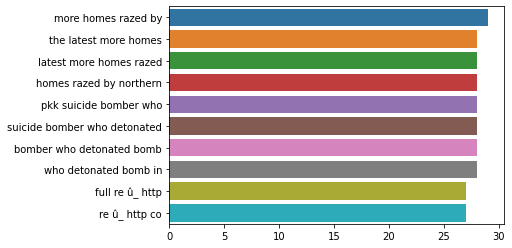

In [71]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
import seaborn as sns

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

top_tri_grams=get_top_ngram(tweets,n=4)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

In [81]:
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['text']:
        words=[w for w in word_tokenize(news) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(trainDf)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import gensim

dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

In [ ]:
tk_text3, vocab3 = tokenize_data(corpus, stop_words)

min_used = 2
for word in vocab2.copy():
  if vocab3[word] < min_used:
    del vocab3[word]

# criar a matriz bag-of-words
matrix3, columns3 = to_matrix(tk_text3, vocab3)
# convertendo a matriz para um array numpy
matrix3 = np.array(matrix3)
print(matrix3.shape)
# visualizando uma amostra
pd.DataFrame(matrix3[0:10], columns=columns3)

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = vocab.len()
embedding_dim = 16
max_length = 100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")